下载Nasbench库和数据集

In [ ]:
# This code was written in TF 1.12 but should be supported all the way through
# TF 1.15. Untested in TF 2.0+.
%tensorflow_version 1.x

# Download the raw data (only 108 epoch data points, for full dataset,
# uncomment the second line for nasbench_full.tfrecord).

!curl -O https://storage.googleapis.com/nasbench/nasbench_only108.tfrecord
# !curl -O https://storage.googleapis.com/nasbench/nasbench_full.tfrecord

# Clone and install the code and dependencies.

!git clone https://github.com/google-research/nasbench
!pip install ./nasbench

# Initialize the NASBench object which parses the raw data into memory (this
# should only be run once as it takes up to a few minutes).
from nasbench import api

# Use nasbench_full.tfrecord for full dataset (run download command above).
nasbench = api.NASBench('nasbench_only108.tfrecord')

导入使用的库和配置变量

In [2]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import random

INPUT = 'input'           # 输入层
OUTPUT = 'output'          # 输出层
CONV3X3 = 'conv3x3-bn-relu'     # 卷积3×3
CONV1X1 = 'conv1x1-bn-relu'     # 卷积1×1
MAXPOOL3X3 = 'maxpool3x3'      # 最大值池化3×3
NUM_VERTICES = 7           # 隐藏节点数
MAX_EDGES = 9            # 最大连接边数
EDGE_SPOTS = NUM_VERTICES * (NUM_VERTICES - 1) / 2   # 上三角矩阵大小
OP_SPOTS = NUM_VERTICES - 2                 # 除去输入输出层的隐藏节点数
ALLOWED_OPS = [CONV3X3, CONV1X1, MAXPOOL3X3]        # 允许的边操作
ALLOWED_EDGES = [0, 1]                    # 二值化邻接矩阵

regularization evolution实现

In [8]:
def random_spec():
  # 返回一个随机的种群，用于进化算法的初始化
  while True: 
    matrix = np.random.choice(ALLOWED_EDGES, size=(NUM_VERTICES, NUM_VERTICES))    # 构造一个大小num_v×num_v的01矩阵
    matrix = np.triu(matrix,1)                              # 保留上三角矩阵，保证有向无环性质
    ops = np.random.choice(ALLOWED_OPS, size=(NUM_VERTICES)).tolist()          # 构造操作矩阵
    ops[0] = INPUT                                   
    ops[-1] = OUTPUT
    spec = api.ModelSpec(matrix=matrix, ops=ops)                    # 通过matrix和ops矩阵构造种群
    if nasbench.is_valid(spec):                             # 判断种群是否满足nasbench规范
      return spec

def mutate_spec(old_spec, mutation_rate=1.0):
  # 演化操作
  while True:
    new_matrix = copy.deepcopy(old_spec.original_matrix)                # 拷贝matrix矩阵
    new_ops = copy.deepcopy(old_spec.original_ops)                   # 拷贝ops矩阵

    # In expectation, V edges flipped (note that most end up being pruned).
    edge_mutation_prob = mutation_rate / NUM_VERTICES                # 演化概率
    for src in range(0, NUM_VERTICES - 1):                     # 进行hidden state的mutation
      for dst in range(src + 1, NUM_VERTICES):
        if random.random() < edge_mutation_prob:
          new_matrix[src, dst] = 1 - new_matrix[src, dst]
          
    # In expectation, one op is resampled.
    op_mutation_prob = mutation_rate / OP_SPOTS                   # 演化概率
    for ind in range(1, NUM_VERTICES - 1):                     # 进行op的mutation
      if random.random() < op_mutation_prob:
        available = [o for o in nasbench.config['available_ops'] if o != new_ops[ind]]
        new_ops[ind] = random.choice(available)
        
    new_spec = api.ModelSpec(new_matrix, new_ops)                   # 判断演化后的种群是否满足nasbench规范
    if nasbench.is_valid(new_spec):
      return new_spec

def random_combination(population, sample_size):
  # 从所有种群中随机采样sample_size个种群
  pool = tuple(population)
  n = len(pool)
  indices = sorted(random.sample(range(n), sample_size))
  return tuple(pool[i] for i in indices)

def regularization_evolution_search(epoch=1000,
                         population_size=50,
                         tournament_size=10,
                         mutation_rate=1.0):
  nasbench.reset_budget_counters()
  best_valids, best_tests = [0.0], [0.0]        # 记录最好种群的准确率
  population = []                      # (validation, spec)元组

  # 随机初始化population_size个种群
  for _ in range(population_size):
    spec = random_spec()
    data = nasbench.query(spec)
    population.append((data['validation_accuracy'], spec))

    # 记录最高准确率
    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])

  # 开始演化
  for _ in range(epoch):
    sample = random_combination(population, tournament_size)    # 从所有种群中随机选择tournament_size个种群（锦标赛种群）
    best_spec = sorted(sample, key=lambda i:i[0])[-1][1]      # 获取锦标赛种群中准确率最高的种群
    new_spec = mutate_spec(best_spec, mutation_rate)        # 将这个最好的种群进行演化

    data = nasbench.query(new_spec)

    # 加入新种群，去掉最老的种群
    population.append((data['validation_accuracy'], new_spec))
    population.pop(0)

    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])

  return best_valids, best_tests

运行算法（epochs次演化）

In [20]:
epochs=10000
best_valids, best_tests = regularization_evolution_search(epoch=epochs)
print("search end")

search end


构造实验结果图

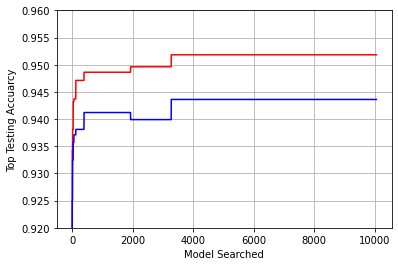

In [22]:
x=np.arange(len(best_tests))
plt.xlabel("Model Searched")
plt.ylabel("Top Testing Accuarcy")
plt.ylim(0.92, 0.96)
plt.grid()
plt.plot(x,best_valids,color='red',label='valid')
plt.plot(x,best_tests,color='blue',label='test')
plt.show()